# Logistic Regression

## Importing Processed Dataset

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/Users/svr/Desktop/DSBA/NLP/FINAL/IMDB Dataset proccessed.csv')
data.head()

,review,sentiment
0,reviewer mention watch oz episode hook right e...,1
1,wonderful little production filming technique ...,1
2,I think wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


## Data Split

In [3]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data["review"]  # Use processed text column
y = data["sentiment"]  # Target labels (0 or 1)

# Split dataset into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y  # stratify ensures balanced classes
)

print("Data Split Done..")


Data Split Done..


# TF-IDF Vectorization (Feature Extraction)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=20000)

# Fit TF-IDF on cleaned training data
vectoriser.fit(X_train)

print('Vectoriser fitted.')
print('No. of feature words:', len(vectoriser.get_feature_names_out()))


Vectoriser fitted.
No. of feature words: 20000


In [5]:
# Apply transformation to convert text to TF-IDF vectors
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

print('Data Transformed.')


Data Transformed.


# Base Logistic Regression Model

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize a base logistic regression model
lr = LogisticRegression(solver='liblinear')

# Fit the model on the training data
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-score: {f1:.4f}")

print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))


✅ Accuracy: 0.8917
✅ Precision: 0.8923
✅ Recall: 0.8917
✅ F1-score: 0.8917

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5000
           1       0.88      0.91      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## Base Model Confusion Matrics


🔹 Confusion Matrix:
[[4360  640]
 [ 443 4557]]


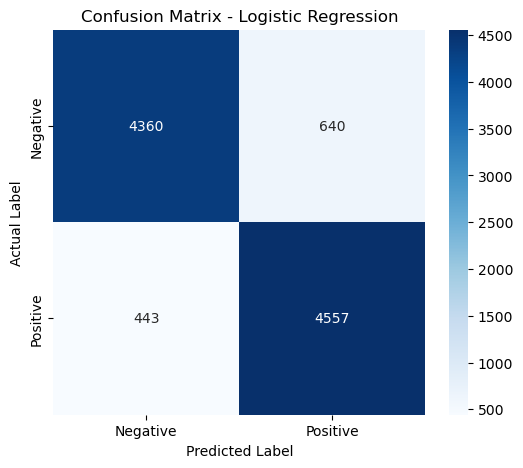

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n🔹 Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


# Logistic Regression Hyper Parameter Tuning with Randomizedsearch

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'C': np.logspace(-3, 2, 50),         # Values from 0.001 to 100
    'penalty': ['l1', 'l2'],              # Regularisation type
    'solver': ['liblinear', 'saga'],      # Solvers that support l1 and l2 penalties
    'class_weight': [None, 'balanced'],   # Handle class imbalance
    'max_iter': [1000, 5000, 10000]        # Maximum iterations for convergence
}

# Set up RandomizedSearchCV with 5-fold cross-validation (using 20 iterations for speed)
rand_search = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV on the training data
rand_search.fit(X_train, y_train)

# Output the best hyperparameters found by RandomizedSearchCV
print("Randomized Search Best Parameters:")
print(rand_search.best_params_)




/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Randomized Search Best Parameters:
{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'class_weight': 'balanced', 'C': 2.9470517025518097}


### Gridsearchcv

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# best parameters from RandomizedSearchCV
best_params_rand = {
    'C': 2.9470517025518097,
    'penalty': 'l2',
    'solver': 'liblinear',
    'class_weight': 'balanced',
    'max_iter': 10000
}

# Create a smaller grid around those best parameters
param_grid = {
    # Vary C around the best value from RandomizedSearchCV
    'C': [
        best_params_rand['C'] * 0.8,
        best_params_rand['C'],
        best_params_rand['C'] * 1.2
    ],
    # Keep the best penalty, but you could include 'l1' if you like
    'penalty': [best_params_rand['penalty']],
    # Keep the best solver, or try including 'saga' if you wish
    'solver': [best_params_rand['solver']],
    # Keep the best class_weight, or try [None, 'balanced']
    'class_weight': [best_params_rand['class_weight']],
    # Let’s check the best max_iter and maybe one higher value
    'max_iter': [best_params_rand['max_iter'], best_params_rand['max_iter'] * 2]
}

# Set up GridSearchCV using 5-fold cross-validation
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1  # use all available cores
)

# Fit grid search on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_lr = grid_search.best_estimator_
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

# Make predictions using the best model
y_pred_best = best_lr.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='weighted')
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')

# Print results
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))



Best Hyperparameters from GridSearchCV:
{'C': 2.357641362041448, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}

Accuracy: 0.8937
Precision: 0.8940
Recall: 0.8937
F1-score: 0.8937

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.91      0.90      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# Confusion Matrics for Tuned Model

Confusion Matrix (Array Form):
[[4399  601]
 [ 462 4538]]


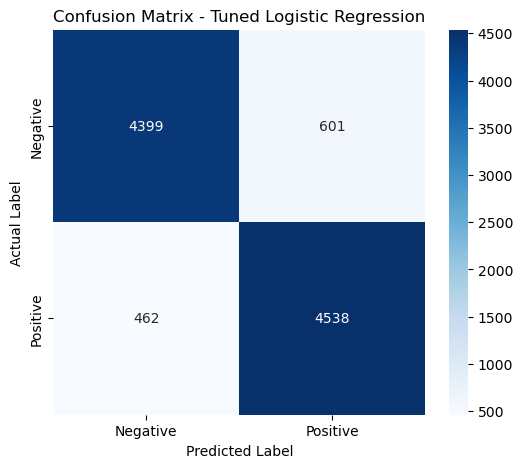

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use the best model to make predictions on the test set
y_pred_best = best_lr.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

print("Confusion Matrix (Array Form):")
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.show()


# ROC Curve

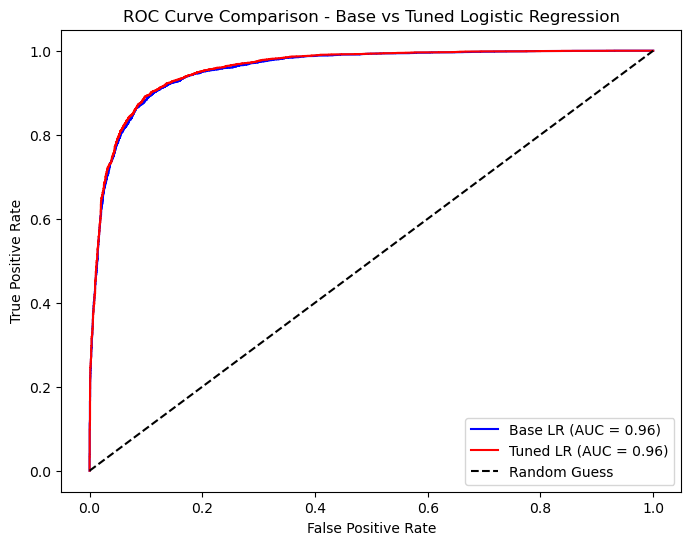

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class from both models
y_proba_base = lr.predict_proba(X_test)[:, 1]
y_proba_tuned = best_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the base model
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
auc_base = roc_auc_score(y_test, y_proba_base)

# Compute ROC curve and AUC for the tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
auc_tuned = roc_auc_score(y_test, y_proba_tuned)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f'Base LR (AUC = {auc_base:.2f})', color='blue')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned LR (AUC = {auc_tuned:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Base vs Tuned Logistic Regression')
plt.legend(loc='lower right')
plt.show()
